In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
rng = np.random.default_rng()
plt.rcParams["figure.figsize"]=(15, 10)
np.set_printoptions(precision=3)

In [2]:
# Make Dynamics Matrix
def make_A(N, k, c):
    A = np.zeros([2*(N+1), 2*(N+1)])
    for i in range(N):
      A[2*i, 2*i+1]     = 1
      A[2*i+1, 2*i+1]   = -c

      A[2*i+1, 2*i]     = -k[i]-k[i+1]
      A[2*i+1, 2*(i-1)] =  k[i]
      A[2*i+1, 2*(i+1)] =       k[i+1]
    A[1, -2] = 0
    return A

# Make Starting Vector
def make_start(N, L):
    start_pos = np.linspace(0, L, N+1)
    start_vec = np.empty(2*(N+1))
    for i in range(N):
      start_vec[2*i] = start_pos[i]
      start_vec[2*i+1] = 0
    start_vec[-2] = L
    start_vec[-1] = 0
    return start_vec

# RK4 step
def RK4(A, state_vec, dt):
    k1 = A@(state_vec)
    k2 = A@(state_vec+ k1*dt/2)
    k3 = A@(state_vec+ k2*dt/2)
    k4 = A@(state_vec+ k3*dt)
    return state_vec + dt/6*(k1 + 2*k2 + 3*k3 + k4)

# Get the energy of a current state
def get_E(state_vec, k):
    energy = 0
    energy += k[0]*state_vec[0]**2/2
    for i in range(N):
        p = state_vec[2*i+1]
        energy += p**2/2

        x = state_vec[2*(i+1)] - state_vec[2*i]
        energy += k[i+1]*x**2/2
    return energy

# Run a simulation with RK4 integration
def run_RK4(start_vec, A, k, dt, Nt):
    N_state = len(A)
    state_vec = np.empty([N_state, Nt])
    state_vec[:, 0] = start_vec
    E = np.empty(Nt)
    E[0] = get_E(state_vec[:, 0], k)
    for i in range(1, Nt):
      state_vec[:, i] = RK4(A, state_vec[:, i-1], dt)
      E[i] = get_E(state_vec[:, i], k)

      if i % 100000 == 0:
        print('T = ', int(time_vec[i]))
    return state_vec, E

# Run a simulation with Euler integration
def run_Euler(start_vec, A, k, dt, Nt):
    N_state = len(A)
    state_vec = np.empty([N_state, Nt])
    state_vec[:, 0] = start_vec
    E = np.empty(Nt)
    E[0] = get_E(state_vec[:, 0], k)
    for i in range(1, Nt):
      state_vec[:, i] = state_vec[:, i-1] + (A@state_vec[:, i-1])*dt
      E[i] = get_E(state_vec[:, i], k)

      if i % 100000 == 0:
        print('T = ', int(time_vec[i]))
    return state_vec, E

# Run a simulation with SCN integration
def run_SCN(start_vec, A, k, dt, Nt):
    N_state = len(A)
    state_vec = np.empty([N_state, Nt])
    state_vec[:, 0] = start_vec
    E = np.empty(Nt)
    E[0] = get_E(state_vec[:, 0], k)

    N = 4*N_state
    tau = 0.01

    v = np.zeros([N, Nt])
    r = np.zeros([N, Nt])
    s = np.zeros([N, Nt])

    D = rng.normal(0, 1, [N_state, N])
    D = D/np.linalg.norm(D, axis = 1)[:, None]
    D = (N_state/N)*D

    T = 0.5*np.diag(D.T@D)

    O_s = - D.T@D
    O_r = D.T@(A + tau*np.eye(N_state))@D

    r[:, 0] = np.linalg.pinv(D)@start_vec

    for i in range(1, Nt):

      v[:, i] = (1-tau*dt)*v[:, i-1] + dt*O_r@r[:, i-1] + O_s@s[:, i-1]

      above = np.where(v[:, i] > T)
      if len(above):
          spk = np.argmax(v[:, i])
          s[spk, i] = 1

      r[:, i] = (1-tau*dt)*r[:, i-1] + s[:, i-1]

      state_vec[:, i] = D@r[:, i]


      E[i] = get_E(state_vec[:, i], k)

      if i % 100000 == 0:
        print('T = ', int(time_vec[i]))
    return state_vec, E

# Make plots from the simulation
def plots(state_vec, E):
    for i in range(N+1):
        plt.plot(time_vec, state_vec[2*i, :])
    plt.show()

    plt.plot(time_vec, E)
    plt.ylim(0, 1.5*E[0])
    plt.show()

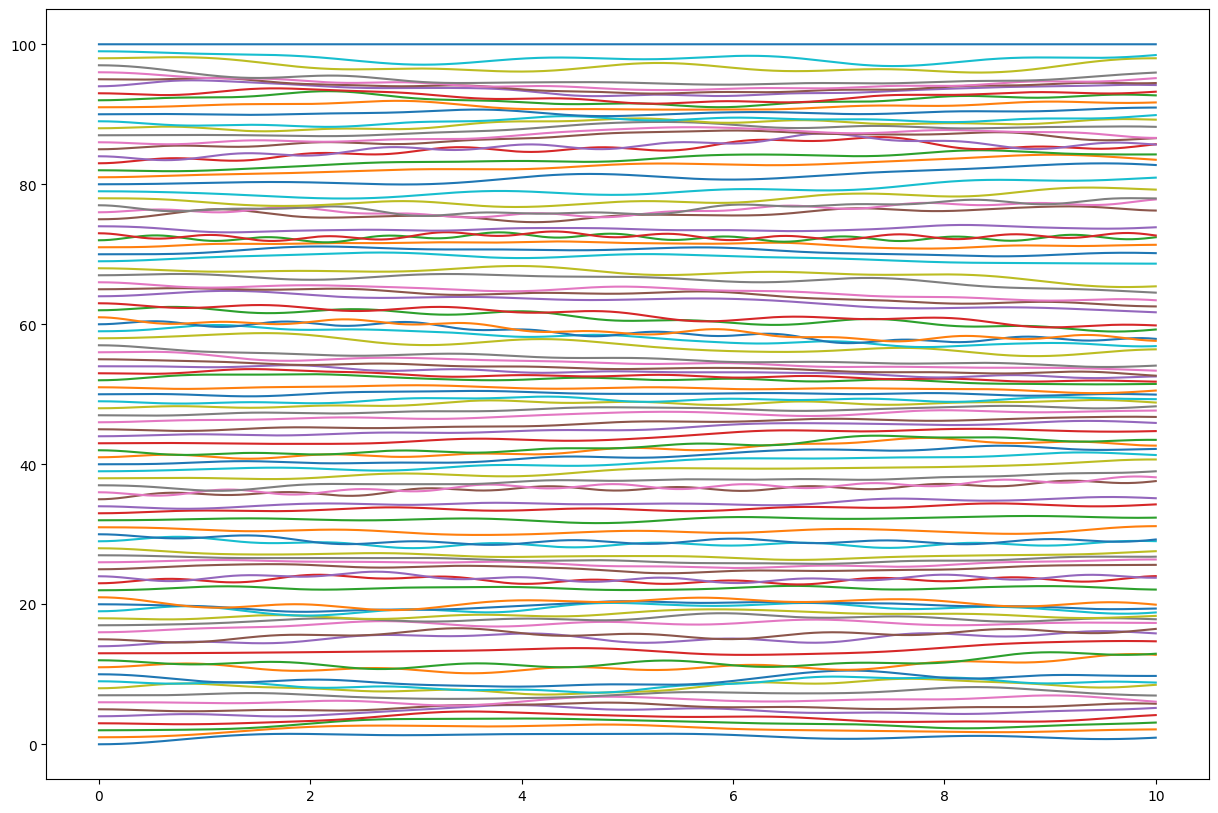

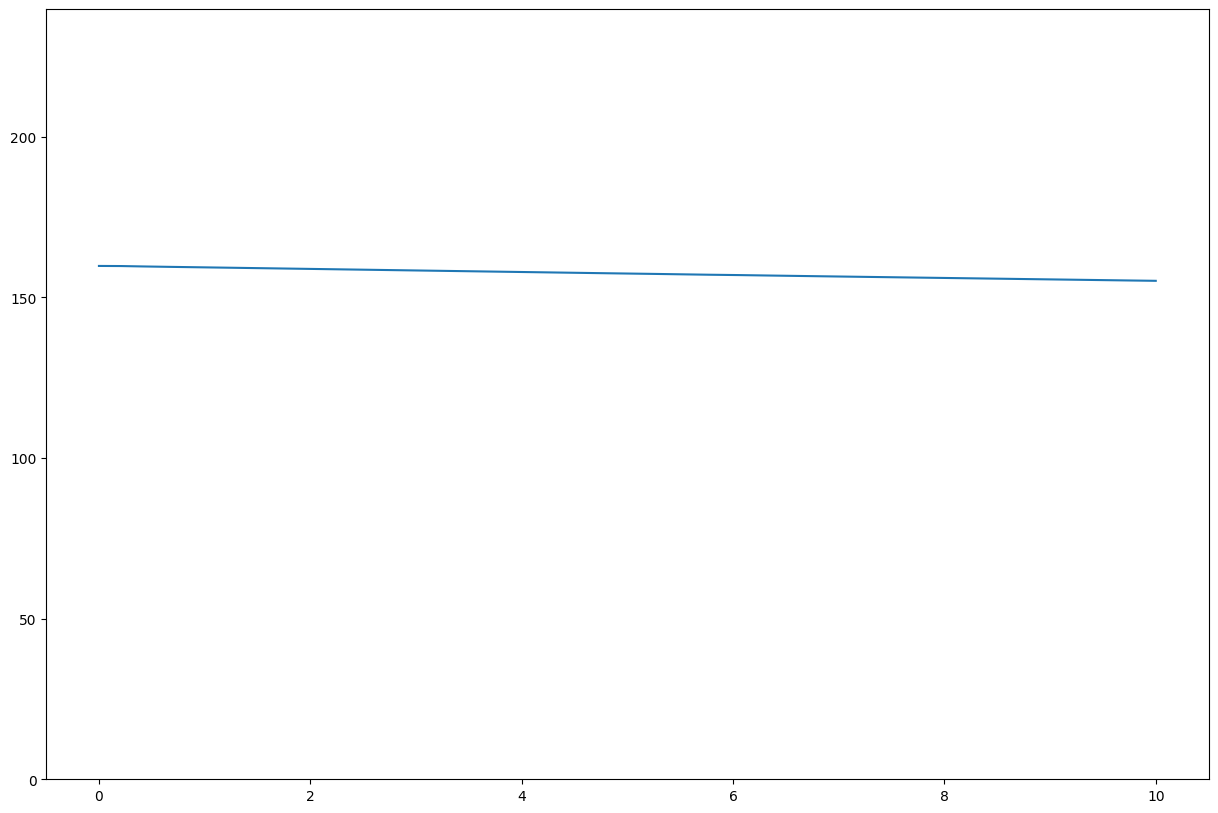

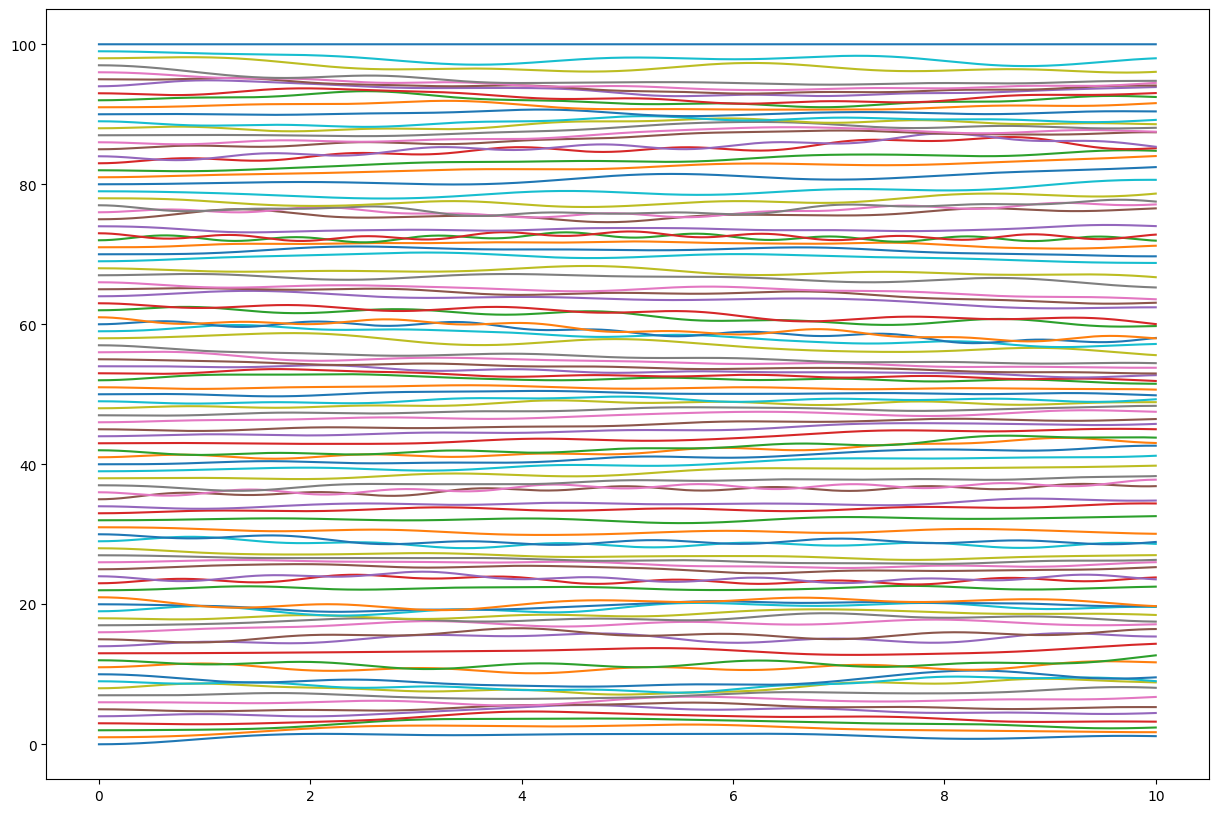

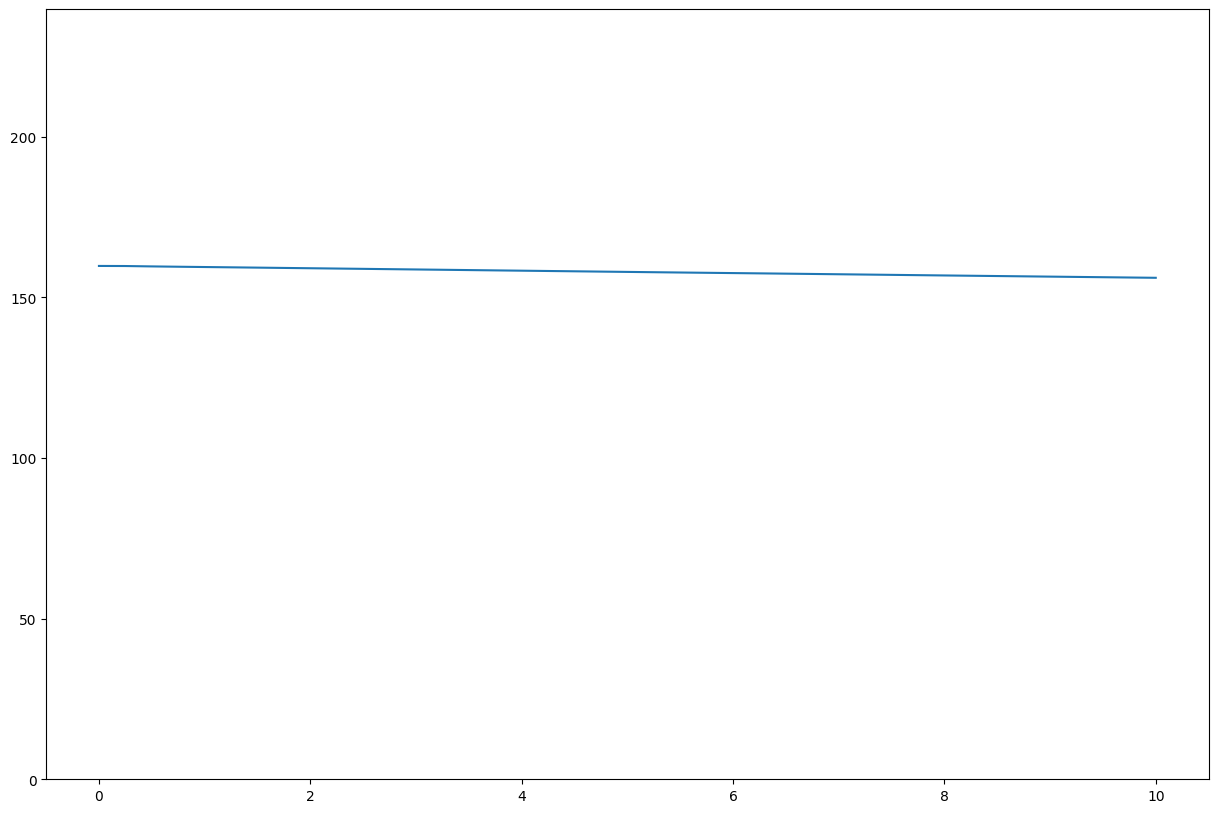

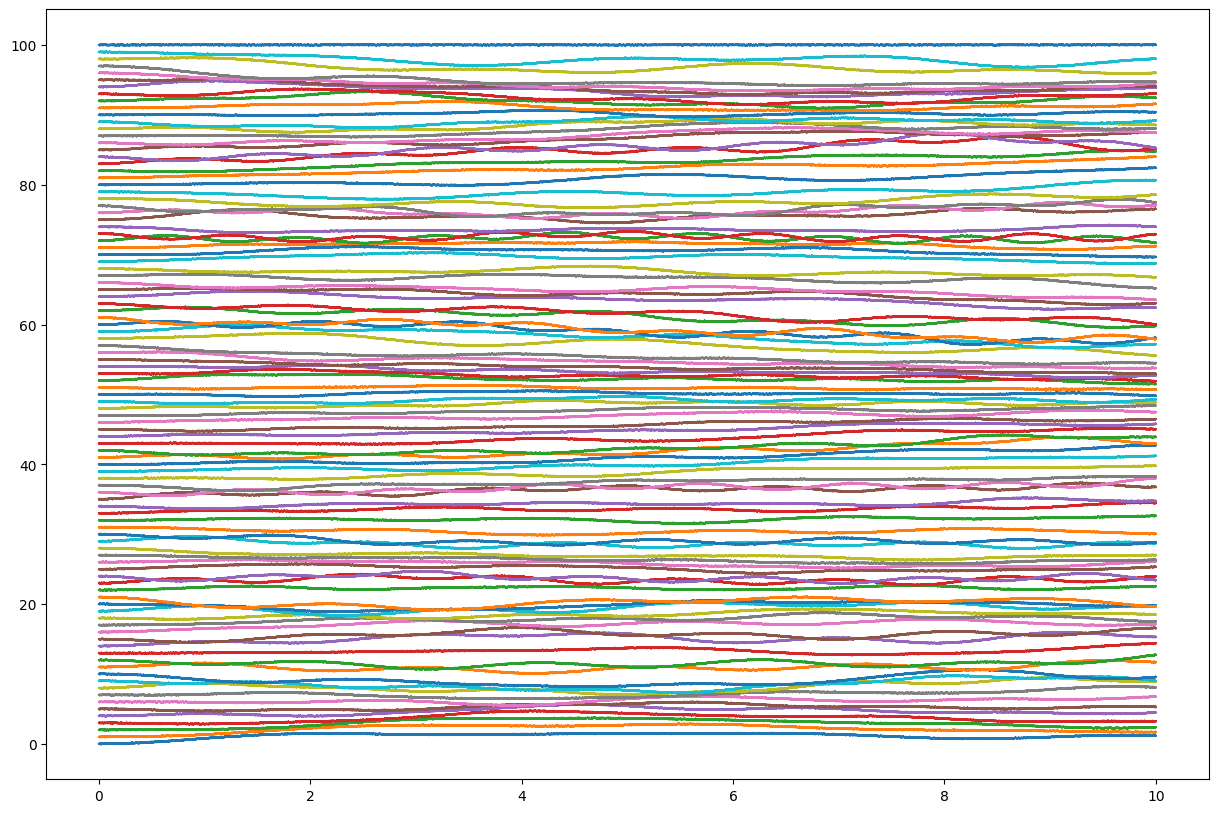

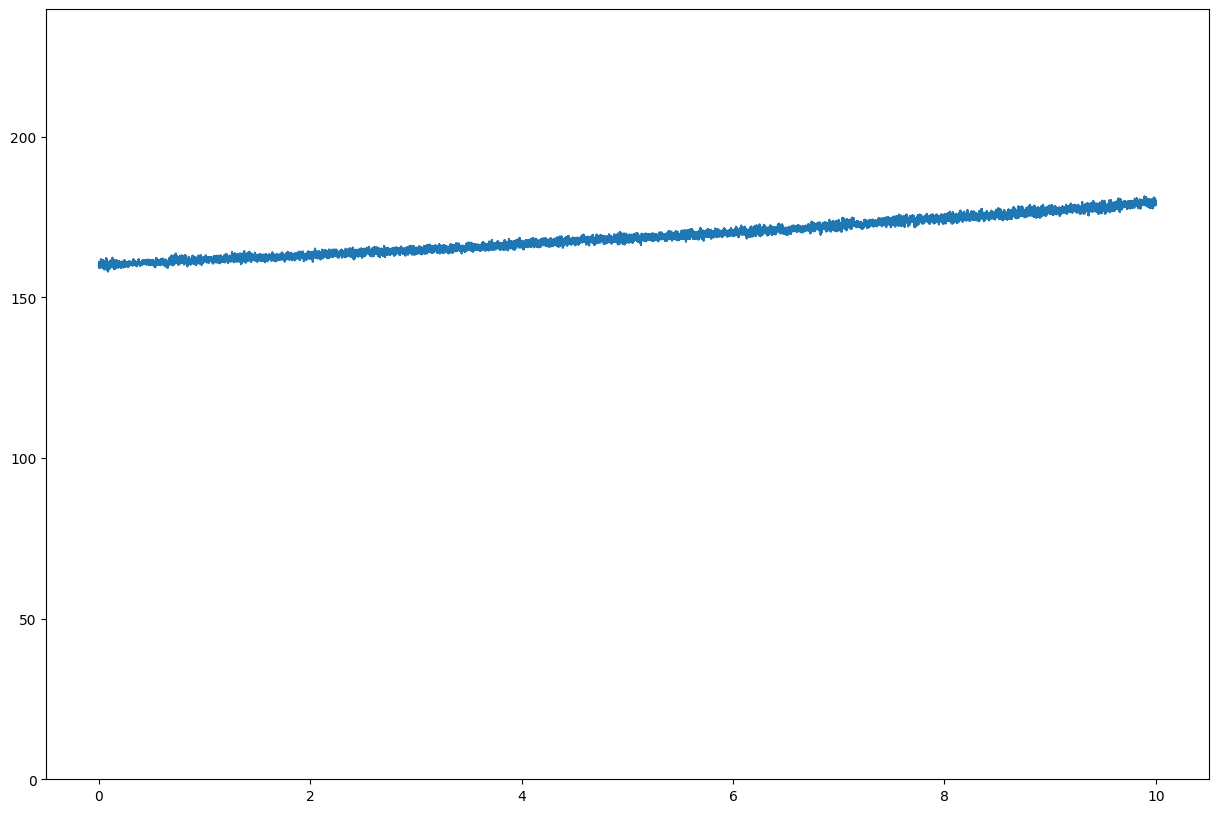

In [3]:
# Setup Sim Parameters
T = 10
dt = 0.0001
Nt = int(T/dt)
time_vec = np.linspace(0, T, Nt)

# Setup Physical Parameters
N = 100
L = 100
c = 0.01
k = 1 + rng.exponential(scale = 2, size = N+1)
A = make_A(N, k, c)
start_vec = make_start(N, L)

# Sim RK4
state_vec_RK4, E_RK4 = run_RK4(start_vec, A, k, dt, Nt)
plots(state_vec_RK4, E_RK4)

# Sim Euler
state_vec_Euler, E_Euler = run_Euler(start_vec, A, k, dt, Nt)
plots(state_vec_Euler, E_Euler)

# Sim SCN
state_vec_SCN, E_SCN = run_SCN(start_vec, A, k, dt, Nt)
plots(state_vec_SCN, E_SCN)